<a href="https://colab.research.google.com/github/cristhiansito123/mai_hand/blob/main/scripts/evaluation/evaluation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Se llama primero al modelo ya entrenado

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive

In [ ]:
import joblib

In [ ]:
# Ruta del archivo del modelo en Google Drive
model_path = '/content/drive/MyDrive/signal_language/asl_dataset/random_forest_model.pkl'

# Cargar el modelo desde Google Drive
model = joblib.load(model_path)

Iniciar cámara

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  #for (x,y,w,h) in faces:
  #    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


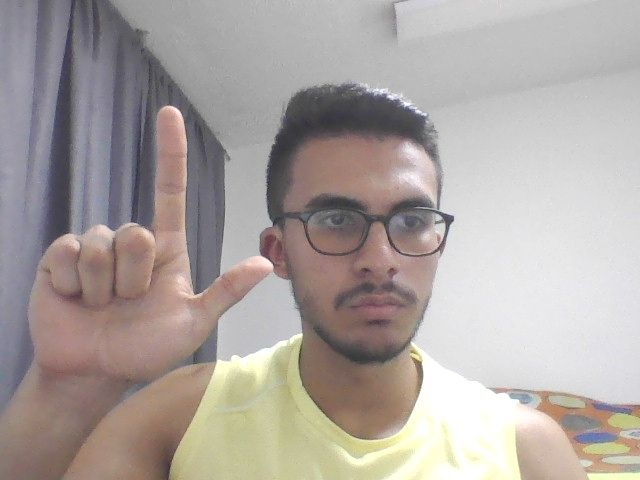

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Cargar imagen

La imagen se cargó correctamente. Forma: (480, 640, 3)


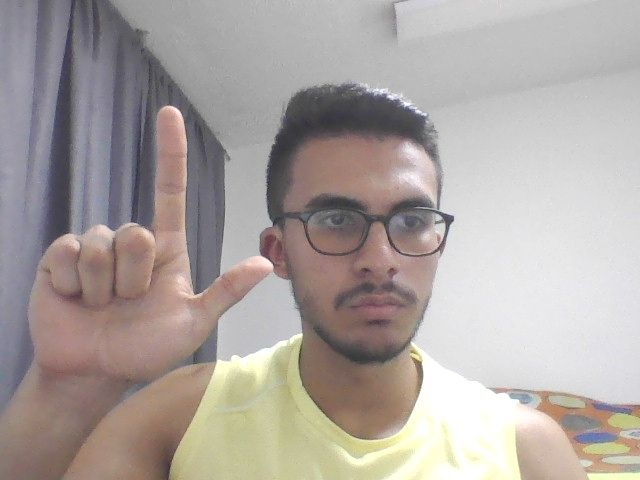

In [ ]:
import csv
import cv2
from google.colab.patches import cv2_imshow

  # Cargar la imagen
imagen_path = 'photo.jpg'  # Ruta de la imagen

imagen = cv2.imread(imagen_path)

   # Verificar si la imagen se cargó correctamente

if imagen is None:
      print(f"No se pudo cargar la imagen en {imagen_path}")
else:
      print(f"La imagen se cargó correctamente. Forma: {imagen.shape}")

cv2_imshow(imagen)

Recortar imagen

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


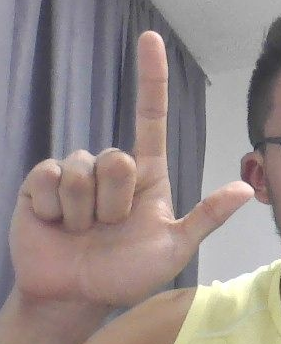

In [ ]:
import cv2
import mediapipe as mp
import csv
from google.colab.patches import cv2_imshow

  # Configurar la detección de manos con Mediapipe
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands


with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
      # Convertir la imagen de BGR a RGB
      image_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
      # Procesar la imagen con Mediapipe
      resultado = hands.process(image_rgb)
      # Verificar si se detectó alguna mano

if resultado.multi_hand_landmarks:

      # Obtener los puntos de referencia de la mano
      mano_landmarks = resultado.multi_hand_landmarks[0]

      # Determinar los límites del rectángulo de recorte
      altura, ancho, _ = imagen.shape
      puntos_x = [punto.x * ancho for punto in mano_landmarks.landmark]
      puntos_y = [punto.y * altura for punto in mano_landmarks.landmark]
      min_x, max_x = int(min(puntos_x)), int(max(puntos_x))
      min_y, max_y = int(min(puntos_y)), int(max(puntos_y))

      # Determinar el factor de expansión del recorte
      factor_expansion = 0.2  # Ajusta este valor según tus necesidades (0.2 es solo un ejemplo)

      # Calcular los valores de expansión
      expansion_x = int((max_x - min_x) * factor_expansion)
      expansion_y = int((max_y - min_y) * factor_expansion)

      # Ajustar los límites del recorte
      min_x -= expansion_x
      max_x += expansion_x
      min_y -= expansion_y
      max_y += expansion_y

      # Asegurarse de que los límites no excedan las dimensiones de la imagen
      min_x = max(0, min_x)
      max_x = min(ancho - 1, max_x)
      min_y = max(0, min_y)
      max_y = min(altura - 1, max_y)

      # Recortar la imagen alrededor de la mano con los nuevos límites
      imagen_recortada = imagen[min_y:max_y, min_x:max_x]
      cv2_imshow(imagen_recortada)

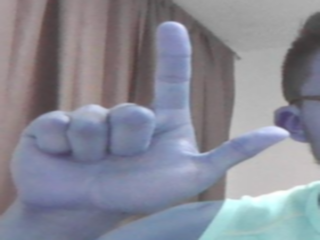

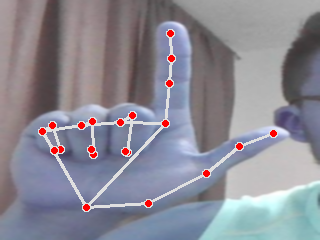

In [ ]:
import cv2
import mediapipe as mp
import csv
from google.colab.patches import cv2_imshow

   # Configurar la detección de manos con Mediapipe
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands


with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.1) as hands:
      # Convertir la imagen de BGR a RGB

      image_rgb = cv2.cvtColor(imagen_recortada, cv2.COLOR_BGR2RGB)
      blurred_image = cv2.GaussianBlur(image_rgb, (5, 5), 0)

      # Filtrado para priorizar la mano
      imagen_recortada2 = cv2.resize(blurred_image, (320, 240))

      # Procesar la imagen con Mediapipe
      resultado = hands.process(image_rgb)
      # Verificar si se detectó alguna mano

      cv2_imshow(imagen_recortada2)

          # Guardar los puntos y vectores en un archivo CSV
if resultado.multi_hand_landmarks:

              hand_landmarks_cropped = resultado.multi_hand_landmarks[0]
              landmarks_data = []
              for landmark in hand_landmarks_cropped.landmark:
                  landmarks_data.append((landmark.x, landmark.y, landmark.z))

              #csv_path = 'landmarks.csv'  # Ruta del archivo CSV
              #with open(csv_path, 'w', newline='') as csv_file:
              #    writer = csv.writer(csv_file)
              #    writer.writerows(landmarks_data)

              #print(f"Se guardaron los puntos y vectores en {csv_path}")

          # Mostrar la imagen final con los vectores y puntos
              mp_drawing.draw_landmarks(
                            imagen_recortada2, hand_landmarks_cropped, mp_hands.HAND_CONNECTIONS
                        )
              cv2_imshow(imagen_recortada2)

In [ ]:
landmarks_data = np.asarray(landmarks_data)

In [ ]:
landmarks_data=landmarks_data.reshape(landmarks_data.shape[0]*landmarks_data.shape[1])

In [ ]:
landmarks_data=landmarks_data.reshape(1, -1)

In [ ]:
model.predict(landmarks_data)

array(['l'], dtype='<U1')